# **Pricing options and computing implied volatilities using neural networks**

---





We'll start by importing all the dependencies and defining all the functions necessary to computing the prices, manely: `BS(S,K,tau,r,sigma)`, `Heston_2(S,K,tau,mrs,r,volvol,v_bar,rho,sigma,L,N)` and `implied_vol(S,K,tau,r,[...])` in its two variations.
Note: if you'd like to run this code, make sure to install the smt package (`pip install smt`) which contains the LHS (Latin Hypercube Sampling) method we'll use to sample from our parameter space.

The parameters are :
<br>
- S : spot price of the underlying
- K : strike
- tau : time to maturity
- r : risk free interest rate
- sigma : in the BS model it's the volatility, and in the Heston model it's the initial volatility
- mrs : mean reversion speed
- v_bar : long term variance
- volvol : volatily of the variance
- rho : brownian correlation
<br> The code implementing the COS method was inspired by the COS-FFT project in the github reposiroty : https://github.com/larsphilipp/AdvNum19_COS-FFT

The data generated for the Black-Scholes model is in the file titled "BS_data.pt" with each column is m, tau, r, sigma, price in that order. The one for the Heston model is in the file titled "H_data.pt" with each column being m, tau, mrs, r, volvol, v_bar, rho, sigma, price in that order. And lastly the implied volatilities data in in the file titled "iv_data.pt" with the same columns as H_data plus a last column with the implied volatilities. All these files are tensors and can be loaded using `torch.load(file_name)`

Similarly, the Black-Scholes and the Heston and the (last) implied volatility ANNs are also in the files titled "BS_ANN.pt", "Heston_ANN.pt" and "iv_ANN_2.pt" respectively.

In [ ]:
from tqdm import tqdm
import numpy as np
from scipy.stats import norm
from scipy import optimize
import smt
from smt.sampling_methods import LHS
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import plotly.express as px


def BS(S,K,tau,r,sigma):
  '''
  Gives the scaled price of a european option as given by the closed B-S formula
  '''
  d_1 = np.divide((np.log(np.divide(S,K)) + (r+0.5*np.multiply(np.power(sigma,2),tau))), (np.multiply(sigma,np.sqrt(tau))))
  d_2 = d_1 - np.multiply(sigma,np.sqrt(tau))

  V = np.multiply(norm.cdf(x=d_1),S) - np.multiply(np.multiply(norm.cdf(x=d_2),K),np.exp(-np.multiply(r,tau)))

  return V/K

def truncation(L,tau,mrs,r,volvol,v_bar,rho,sigma):
  '''
  Finds the integration range for the COS method
  L : truncation parameter
  '''
  c1 = r* tau + (1 - np.exp(-mrs * tau)) * (v_bar - sigma)/(2 * mrs) - v_bar * tau / 2 # this is the first order cumulant of the characterisctic function of the log-asset price

  c2 = 1/(8 * np.power(mrs,3)) * (volvol * tau * mrs * np.exp(-mrs * tau) \
      * (sigma - v_bar) * (8 * mrs * rho - 4 * volvol) \
      + mrs * rho * volvol * (1 - np.exp(-mrs * tau)) * (16 * v_bar - 8 * sigma) \
      + 2 * v_bar * mrs * tau * (-4 * mrs * rho * volvol + np.power(volvol,2) + 4 * np.power(mrs,2)) \
      + np.power(volvol,2) * ((v_bar - 2 * sigma) * np.exp(-2 * mrs * tau) \
      + v_bar * (6 * np.exp(-mrs * tau) - 7) + 2 * sigma) \
      + 8 * np.power(mrs,2) * (sigma - v_bar) * (1 - np.exp(-mrs * tau))) # this is the second order cumulant of the characterisctic function of the log-asset price

  a = c1 - L * np.sqrt(np.abs(c2))
  b = c1 + L * np.sqrt(np.abs(c2))

  return a, b

def cosSerExp(a,b,c,d,k):
  '''
  The cosine series coefficients of g(y)=exp(y) on [c,d] included in [a,b]
  k : positive integer

  '''
  bma = b-a
  uu  = k * np.pi/bma
  chi =  (1/(1 + np.power(uu,2)))*(np.cos(uu*(d-a))*np.exp(d) - np.cos(uu*(c-a))*np.exp(c) + uu*np.sin(uu*(d-a))*np.exp(d) - uu*np.sin(uu*(c-a))*np.exp(c))

  return chi

def cosSer1(a,b,c,d,k):
  '''
  The cosine series coefficients of g(y)=1 on [c,d] included in [a,b]
  k : positive integer

  '''
  bma    = b-a
  uu     = k * np.pi/bma
  uu[0]  = 1
  psi    = (1/uu)*(np.sin(uu*(d-a)) - np.sin(uu*(c-a)))
  psi[0] = d-c
  return psi

def charFuncHestonFO(u,tau,mrs,r,volvol,v_bar,rho,sigma):
  '''
  The characteristic function of the Heston log-asset price evaluated at u
  '''
  d = np.sqrt(np.power(mrs - 1j*rho*volvol*u, 2) + np.power(volvol,2) * (np.power(u,2) + u*1j))
  g = (mrs - 1j*rho*volvol*u - d)/(mrs - 1j*rho*volvol*u + d)
  C = (mrs*v_bar/np.power(volvol,2)) * ((mrs - 1j*rho*volvol*u - d)*tau - 2*np.log((1 - g * np.exp(-d * tau))/(1-g)))
  D = 1j*r*u*tau + (sigma/np.power(volvol,2)) * ((1 - np.exp(-d*tau))/(1 - g*np.exp(-d*tau))) * (mrs - 1j*rho*volvol*u - d)
  phi = np.exp(D) * np.exp(C)
  return phi

def Heston(S,K,tau,mrs,r,volvol,v_bar,rho,sigma,L,N):
  '''
  Calculates the price of a european call option with a Heston asset and using the COS method
  Initial asset price S, time to maturity tau, strike K with the rest of the Heston parameters
  '''
  k = np.arange(N)
  x = np.log(S/K)
  a,b = truncation(L,tau,mrs,r,volvol,v_bar,rho,sigma)
  u = k*np.pi/(b-a)

  phi_heston = charFuncHestonFO(u,tau,mrs,r,volvol,v_bar,rho,sigma)
  ExpTerm = np.exp(1j*k*np.pi*(x-a)/(b-a))
  Fk = np.real(phi_heston*ExpTerm)
  Fk[0] = 0.5*Fk[0]
  UkCall = 2/(b-a)*(cosSerExp(a,b,0,b,k) - cosSer1(a,b,0,b,k))

  V = K*np.exp(-r*tau)*np.sum(np.multiply(Fk,UkCall))

  return V

def Heston_2(S,K,tau,mrs,r,volvol,v_bar,rho,sigma,L,N):
  '''
  Calculates the price of a european call option with a Heston asset and using the COS method but with put-call parity.
  In fact, COS method doesn't give good results for deep OTM calls, so we'll use this function to generate our data
  '''
  k = np.arange(N)
  x = np.log(S/K)
  a,b = truncation(L,tau,mrs,r,volvol,v_bar,rho,sigma)
  u = k*np.pi/(b-a)

  phi_heston = charFuncHestonFO(u,tau,mrs,r,volvol,v_bar,rho,sigma)
  ExpTerm = np.exp(1j*k*np.pi*(x-a)/(b-a))
  Fk = np.real(phi_heston*ExpTerm)
  Fk[0] = 0.5*Fk[0]
  UkPut  = 2/(b-a)*(cosSer1(a,b,a,0,k) - cosSerExp(a,b,a,0,k))

  V_Put = K * np.sum(Fk*UkPut)*np.exp(-r*tau)

  V_Call = V_Put + S - K*np.exp(-r*tau)

  return V_Call

def implied_vol_(S,K,tau,mrs,r,volvol,v_bar,rho,sigma,L,N,a,b):
  '''
  Finds the B-S implied volatility using Heston otpions price as the "market price" and using Brent's root finding method from scipy.optimize
  '''
  g = lambda x : BS(S,K,tau,r,x)*K - Heston_2(S,K,tau,mrs,r,volvol,v_bar,rho,sigma,L,N)
  root = optimize.brentq(g, a, b)
  return root

def implied_vol(S,K,tau,r,Heston_price):
  '''
  Finds the B-S implied volatility using Heston otpions prices that are already calculated as the "market price" and using Brent's root finding method from scipy.optimize
  '''
  a = -3
  b = 5
  g = lambda x : BS(S,K,tau,r,x)*K - Heston_price
  root = optimize.brentq(g, a, b)
  return root

# Black-Scholes ANN

With all the necessary functions defined, we can move on to generating data for our first model; the BS-ANN. To do this, we define the bounds of our parameter space `(moneyness, tau, r, sigma)` and then we sample one million data points from this space using the `LHS` method, and then compute the BS price using `BS(S,K,tau,r,sigma)`. This cell takes approximately 4 minutes to run.

In [ ]:
S = 100
L = 50
N = 1500

# Latin Hypercube Sampling for the B-S model
M_BS = [0.4,1.6] # moneyness = S0/K
TAU_BS = [0.2,1.1]
R_BS = [0.02,0.1]
SIGMA_BS = [0.01,1.0]

BS_param_space = np.array([M_BS,TAU_BS,R_BS,SIGMA_BS])

sampling_BS = LHS(xlimits=BS_param_space)
num_BS = 10**6 # we will generate 1 million labeled data points
x_BS = sampling_BS(num_BS)

labeled_BS = np.zeros((num_BS,5))
for i in range(num_BS):
  m,tau,r,sigma = x_BS[i,0],x_BS[i,1],x_BS[i,2],x_BS[i,3]
  price = BS(S,S/m,tau,r,sigma)
  labeled_BS[i,:] = [m,tau,r,sigma,price]

BS_data = torch.tensor(labeled_BS).type(torch.float)

# torch.save(BS_data, 'BS_data.pt')

We will define out ANN using the `nn.Module`class. As you will see in the code, it containes 4 hidden layers with the `ReLU` activation function and 400 neurons each. Additonnally, I added the `weights_init` function which initializes the weights of the model using a Glorot uniform distribution.

In [ ]:
class BlackScholes_ANN(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear_relu_stack = nn.Sequential(

        nn.Linear(4,400),
        nn.ReLU(),

        nn.Linear(400,400),
        nn.ReLU(),

        nn.Linear(400,400),
        nn.ReLU(),

        nn.Linear(400,400),
        nn.ReLU(),

        nn.Linear(400,1),
    )

  def forward(self,x):
    target = self.linear_relu_stack(x)
    return target

  def weights_init(self): # initializing parameters using glorot uniform unitialization
    for module in self.modules():
      if isinstance(module, nn.Linear):
        nn.init.xavier_uniform_(module.weight)

def train_loop(dataloader, model, loss_fn, optimizer):
  for batch, (X,y) in enumerate(dataloader):
    # forward compute
    pred = model(X)
    loss = loss_fn(pred,y.unsqueeze(1))

    # backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


We train the model on 90% of the geenrated data, that is 900 000 data points, and the rest is used to test. The chosen loss function is `MSE` and the batch size is 1000. I use Adam optimizer and a learning rate decaying schedule as well in accordance with the article.

In [ ]:
BS_ANN = BlackScholes_ANN()
BS_ANN.weights_init()
loss_function = nn.MSELoss()
batch_size = 1000
epochs = 200
optimizer = torch.optim.Adam(BS_ANN.parameters(), lr=10e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1) # after 10 epochs the new lr is lr*gamma

train_size = int(0.9*num_BS)
X = BS_data[:,:-1] # inputs of the model
Y = BS_data[:,-1] # the price
Xtrain, Xtest = X[:train_size,:], X[train_size:,:]
Ytrain, Ytest = Y[:train_size], Y[train_size:]

train_set = TensorDataset(Xtrain,Ytrain)
train_dataloader = DataLoader(train_set, batch_size=batch_size)

Note : Initially, I planned to train the model for 200 epochs, but it became clear that the model was trained enough by epoch 50 so I stopped the cell there, which is why my results will be plotted for only 50 epochs and not 200.

In [ ]:
training_loss = []
test_loss = []
for epoch in tqdm(range(epochs)):
  running_training_loss = train_loop(train_dataloader, BS_ANN, loss_function, optimizer)
  running_test_loss = loss_function(BS_ANN(Xtest),Ytest.unsqueeze(1))
  running_training_loss = loss_function(BS_ANN(Xtrain),Ytrain.unsqueeze(1))

  test_loss.append(running_test_loss.detach().numpy())
  training_loss.append(running_training_loss.detach().numpy())

  scheduler.step()

Plotting the log loss for training and testing for the 50 epochs gives these plots :

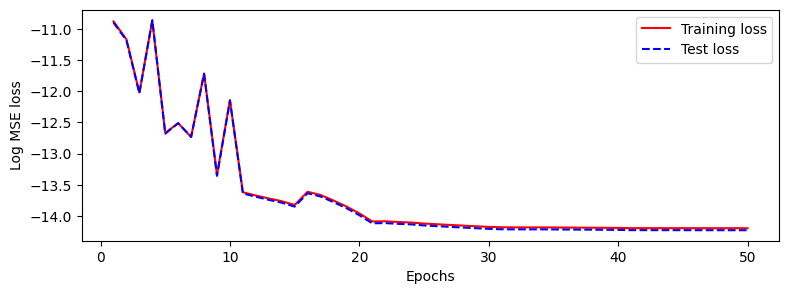

In [ ]:
plt.figure(figsize=(9,3))
plt.plot(np.arange(1,51,1),np.log(np.array(training_loss)),'r',label="Training loss")
plt.plot(np.arange(1,51,1),np.log(np.array(test_loss)),'b',linestyle='dashed',label="Test loss")
plt.xlabel("Epochs")
plt.ylabel("Log MSE loss")
plt.legend()
# plt.savefig("MSE_loss_BS_1mil_50_epochs.png",dpi=1200)

Additionnaly, we can use the model to compute BS option prices, and plot them against the analytic solution :

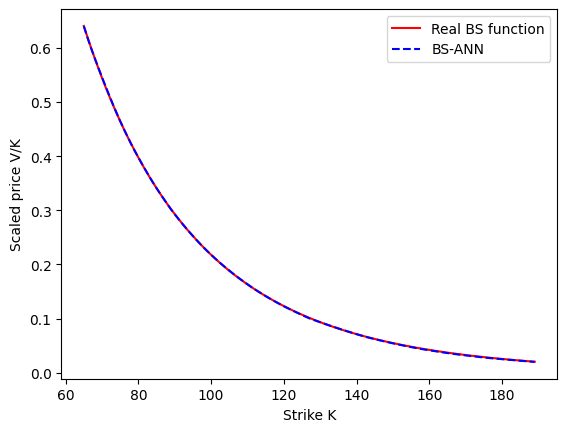

In [ ]:
S = 100
K = np.arange(65,190,1)
tau = 1
r = 0.05
sigma = 0.5

inputs = np.zeros((len(K),4))

for i in range(len(K)):
  inputs[i,:] = [S/K[i],tau,r,sigma]

inputs = torch.tensor(inputs).type(torch.float)

real = BS(S,K,tau,r,sigma)
model = BS_ANN(inputs).detach().numpy()
plt.plot(K,real,'r',label="Real BS function")
plt.plot(K,model,'b',linestyle='dashed',label="BS-ANN")
plt.xlabel("Strike K")
plt.ylabel("Scaled price V/K")
plt.legend()
# plt.savefig("predictions_BS_1mil_50_epochs.png",dpi=1200)

# Heston ANN

We approach this model similarly, generating the data first, then creating the ANN the same way as before.

In [ ]:
S = 100
L = 50
N = 1500

# Latin Hypercube Sampling for the Heston model
M_H = [0.6,1.4] # moneyness = S0/K
TAU_H = [0.1,1.4]
R_H = [0.0,0.1]
RHO = [-0.95,0.0]
MRS = [0.0,2.0]
V_BAR = [0.0,0.5]
VOLVOL = [0.0,0.5]
SIGMA_H = [0.05,0.5]

H_param_space = np.array([M_H,TAU_H,MRS,R_H,VOLVOL,V_BAR,RHO,SIGMA_H])
sampling_H = LHS(xlimits=H_param_space)
num_H = 10**6
# num_H = 1000
x_H = sampling_H(num_H)

labeled_H = np.zeros((num_H,9))
for i in range(num_H):
  m,tau,mrs,r,volvol,v_bar,rho,sigma = x_H[i,0],x_H[i,1],x_H[i,2],x_H[i,3],x_H[i,4],x_H[i,5],x_H[i,6],x_H[i,7]
  price = Heston_2(S,S/m,tau,mrs,r,volvol,v_bar,rho,sigma,L,N)
  labeled_H[i,:] = [m,tau,mrs,r,volvol,v_bar,rho,sigma,price]

H_data = torch.tensor(labeled_H).type(torch.float)

# torch.save(H_data, 'H_data.pt')

In [ ]:
class Heston_ANN(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear_relu_stack = nn.Sequential(

        nn.Linear(8,400),
        nn.ReLU(),

        nn.Linear(400,400),
        nn.ReLU(),

        nn.Linear(400,400),
        nn.ReLU(),

        nn.Linear(400,400),
        nn.ReLU(),

        nn.Linear(400,1),
    )

  def forward(self,x):
    target = self.linear_relu_stack(x)
    return target

  def weights_init(self): # initializing parameters using glorot uniform unitialization
    for module in self.modules():
      if isinstance(module, nn.Linear):
        nn.init.xavier_uniform_(module.weight)

def train_loop(dataloader, model, loss_fn, optimizer):
  for batch, (X,y) in enumerate(dataloader):
    # forward compute
    pred = model(X)
    loss = loss_fn(pred,y.unsqueeze(1))

    # backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [ ]:
Hest_ANN = Heston_ANN()
Hest_ANN.weights_init()
loss_function = nn.MSELoss()
batch_size = 1000
epochs = 100
optimizer = torch.optim.Adam(Hest_ANN.parameters(), lr=10e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

train_size = int(0.9*num_H)
X = H_data[:,:-1] # inputs of the model
Y = H_data[:,-1] # the price
Xtrain, Xtest = X[:train_size,:], X[train_size:,:]
Ytrain, Ytest = Y[:train_size], Y[train_size:]

train_set = TensorDataset(Xtrain,Ytrain)
train_dataloader = DataLoader(train_set, batch_size=batch_size)

We can see that my results aren't as good as the paper. Although it should be noted that in the paper, they did hyperparameter optimization to find the best hyperparameters, which I didn't do. Mainly, they set the number of epochs to 3000 which is not feasable for me.

In [ ]:
training_loss = []
test_loss = []
for epoch in tqdm(range(epochs)):
  running_training_loss = train_loop(train_dataloader, Hest_ANN, loss_function, optimizer)
  running_test_loss = loss_function(Hest_ANN(Xtest),Ytest.unsqueeze(1))
  running_training_loss = loss_function(Hest_ANN(Xtrain),Ytrain.unsqueeze(1))

  if epoch%5==0:
    print("Test loss :", running_test_loss.detach().numpy())

  test_loss.append(running_test_loss.detach().numpy())
  training_loss.append(running_training_loss.detach().numpy())

  scheduler.step()

print("Done!")

  1%|          | 1/100 [01:38<2:41:49, 98.08s/it]

Test loss : 0.96615016


  6%|▌         | 6/100 [09:33<2:29:15, 95.27s/it]

Test loss : 0.23231044


 11%|█         | 11/100 [17:30<2:21:36, 95.47s/it]

Test loss : 0.26515198


 16%|█▌        | 16/100 [25:32<2:14:41, 96.21s/it]

Test loss : 0.2522753


 21%|██        | 21/100 [33:36<2:07:22, 96.74s/it]

Test loss : 0.1536732


 26%|██▌       | 26/100 [41:37<1:58:47, 96.32s/it]

Test loss : 0.094252415


 31%|███       | 31/100 [49:38<1:50:37, 96.19s/it]

Test loss : 0.051547162


 36%|███▌      | 36/100 [57:42<1:43:08, 96.70s/it]

Test loss : 0.046935927


 41%|████      | 41/100 [1:05:47<1:35:36, 97.23s/it]

Test loss : 0.031761926


 46%|████▌     | 46/100 [1:13:56<1:28:12, 98.01s/it]

Test loss : 0.030565593


 51%|█████     | 51/100 [1:22:09<1:20:25, 98.47s/it]

Test loss : 0.029673645


 56%|█████▌    | 56/100 [1:30:29<1:13:10, 99.79s/it] 

Test loss : 0.028855149


 61%|██████    | 61/100 [1:38:57<1:05:53, 101.36s/it]

Test loss : 0.027422914


 66%|██████▌   | 66/100 [1:47:35<58:35, 103.39s/it]

Test loss : 0.027194625


 71%|███████   | 71/100 [1:56:26<51:13, 106.00s/it]

Test loss : 0.027081812


 76%|███████▌  | 76/100 [2:05:31<43:32, 108.86s/it]

Test loss : 0.026996372


 81%|████████  | 81/100 [2:14:57<35:47, 113.04s/it]

Test loss : 0.026885694


 86%|████████▌ | 86/100 [2:24:53<27:43, 118.85s/it]

Test loss : 0.0268579


 91%|█████████ | 91/100 [2:35:21<18:44, 124.97s/it]

Test loss : 0.026848651


 96%|█████████▌| 96/100 [2:46:10<08:39, 129.77s/it]

Test loss : 0.026841717


100%|██████████| 100/100 [2:54:54<00:00, 104.95s/it]

Done!


But at the very least, we can see that the model is not overfitting since the test and training errors are pretty close !

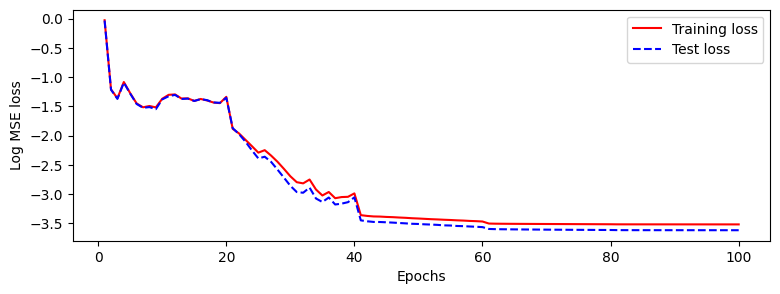

In [ ]:
plt.figure(figsize=(9,3))
plt.plot(np.arange(1,101,1),np.log(np.array(training_loss)),'r',label="Training loss")
plt.plot(np.arange(1,101,1),np.log(np.array(test_loss)),'b',linestyle='dashed',label="Test loss")
plt.xlabel("Epochs")
plt.ylabel("Log MSE loss")
plt.legend()
# plt.savefig("log_MSE_loss_Heston_1mil_100_epochs.png",dpi=1200)

SImilarely to before, we can plot the Heston prices computed by the model against the real ones given by `Heston_2` and `Heston`, and it is clear that the (in-sample) predictions of the model are decent.

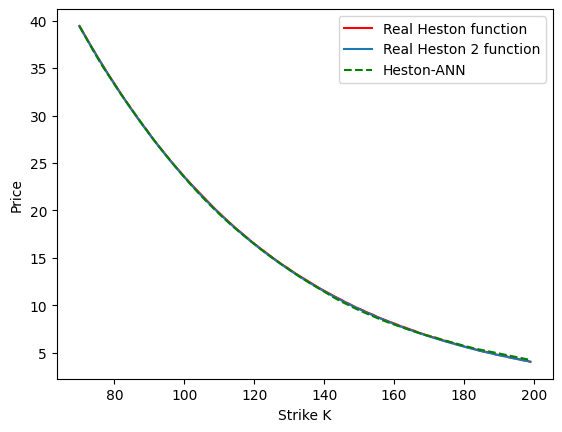

In [ ]:
L = 50
N = 1500
S = 100
K = np.arange(70,200,1)
tau = 1
r = 0.05
sigma = 0.4
volvol = 0.3
v_bar = 0.2
mrs = 1.5

inputs = np.zeros((len(K),8))
real = np.zeros((len(K)))
real2 = np.zeros((len(K)))

for i in range(len(K)):
  inputs[i,:] = [S/K[i],tau,mrs,r,volvol,v_bar,rho,sigma]
  real[i] = Heston(S,K[i],tau,mrs,r,volvol,v_bar,rho,sigma,L,N)
  real2[i] = Heston_2(S,K[i],tau,mrs,r,volvol,v_bar,rho,sigma,L,N)

inputs = torch.tensor(inputs).type(torch.float)

model = Hest_ANN(inputs).detach().numpy()
plt.plot(K,real,'r',label="Real Heston function")
plt.plot(K,real2,label="Real Heston 2 function")
plt.plot(K,model,'g',linestyle='dashed',label="Heston-ANN")
plt.xlabel("Strike K")
plt.ylabel("Price")
plt.legend()
# plt.savefig("predictions_Heston_1mil_50_epochs.png",dpi=1200)

#Implied volatilities ANN


---



There are mutliple ways to go about learning the relationship between prices and implied volatilities. I chose to create my training data like this : use the Heston prices that are computed by `Heston_2` as my market prices, and then compute the implied volatilities using Brent's algorithm.

The first model, and by far the worst, takes only one parameter; the Heston price. We proceed like before :

In [ ]:
class IV_ANN(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear_relu_stack = nn.Sequential(

        nn.Linear(1,400),
        nn.ReLU(),

        nn.Linear(400,400),
        nn.ReLU(),

        nn.Linear(400,400),
        nn.ReLU(),

        nn.Linear(400,400),
        nn.ReLU(),

        nn.Linear(400,1),
    )

  def forward(self,x):
    target = self.linear_relu_stack(x)
    return target

  def weights_init(self): # initializing parameters using glorot uniform unitialization
    for module in self.modules():
      if isinstance(module, nn.Linear):
        nn.init.xavier_uniform_(module.weight)

def train_loop(dataloader, model, loss_fn, optimizer):
  for batch, (X,y) in enumerate(dataloader):
    # forward compute
    pred = model(X)
    loss = loss_fn(pred,y.unsqueeze(1))

    # backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [ ]:
H_data = torch.load("H_data.pt") # H_data.pt contains the 1 million data points generated for the training of the Heston-ANN
S = 100
iv = np.zeros((len(H_data),1))

for i in range(len(H_data)):
  K, tau, r, Heston_price = S/H_data[i,0], H_data[i,1], H_data[i,3], H_data[i,-1]
  iv[i,:] = implied_vol(S,K,tau,r,Heston_price)

In [ ]:
iv_data = np.zeros((len(iv),2))
iv_data[:,1] = iv[:,0]
iv_data[:,0] = H_data[:,-1].detach().numpy()
iv_data = torch.tensor(iv_data).type(torch.float)
# torch.save(iv_data, 'iv_data.pt')

In [ ]:
iv_ANN = IV_ANN()
iv_ANN.weights_init()
loss_function = nn.MSELoss()
batch_size = 1000
epochs = 60
optimizer = torch.optim.Adam(iv_ANN.parameters(), lr=10e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

num_iv = len(iv_data)

train_size = int(0.9*num_iv)
X = iv_data[:,:-1] # inputs of the model : Heston prices
Y = iv_data[:,-1] # outputs : BS implied volatility calculated with brent's method
Xtrain, Xtest = X[:train_size,:], X[train_size:,:]
Ytrain, Ytest = Y[:train_size], Y[train_size:]

train_set = TensorDataset(Xtrain,Ytrain)
train_dataloader = DataLoader(train_set, batch_size=batch_size)

In [ ]:
training_loss = []
test_loss = []
for epoch in tqdm(range(epochs)):
  running_training_loss = train_loop(train_dataloader, iv_ANN, loss_function, optimizer)
  running_test_loss = loss_function(iv_ANN(Xtest),Ytest.unsqueeze(1))
  running_training_loss = loss_function(iv_ANN(Xtrain),Ytrain.unsqueeze(1))

  if epoch%5==0:
    print("Test loss :", running_test_loss.detach().numpy())
    print(" Training loss :", running_training_loss.detach().numpy())


  test_loss.append(running_test_loss.detach().numpy())
  training_loss.append(running_training_loss.detach().numpy())

  scheduler.step()

print("Done!")

  2%|▏         | 1/60 [01:39<1:37:32, 99.20s/it]

Test loss : 0.011224918
 Training loss : 0.011119721


 10%|█         | 6/60 [10:16<1:33:32, 103.93s/it]

Test loss : 0.011278517
 Training loss : 0.011154125


 18%|█▊        | 11/60 [18:44<1:23:18, 102.02s/it]

Test loss : 0.011163407
 Training loss : 0.011063045


 27%|██▋       | 16/60 [27:21<1:15:12, 102.55s/it]

Test loss : 0.011179931
 Training loss : 0.011081482


 35%|███▌      | 21/60 [35:48<1:06:04, 101.66s/it]

Test loss : 0.011081031
 Training loss : 0.010992861


 43%|████▎     | 26/60 [44:32<58:59, 104.11s/it]  

Test loss : 0.0110805025
 Training loss : 0.010992527


 52%|█████▏    | 31/60 [53:05<49:43, 102.87s/it]

Test loss : 0.011077589
 Training loss : 0.010990782


 60%|██████    | 36/60 [1:01:39<41:07, 102.80s/it]

Test loss : 0.011077414
 Training loss : 0.010990626


 68%|██████▊   | 41/60 [1:10:23<33:13, 104.90s/it]

Test loss : 0.011077115
 Training loss : 0.010990456


 77%|███████▋  | 46/60 [1:19:02<24:17, 104.08s/it]

Test loss : 0.01107701
 Training loss : 0.010990425


 85%|████████▌ | 51/60 [1:27:49<15:48, 105.43s/it]

Test loss : 0.011076996
 Training loss : 0.0109904185


 93%|█████████▎| 56/60 [1:36:46<07:08, 107.06s/it]

Test loss : 0.011077005
 Training loss : 0.0109904185


100%|██████████| 60/60 [1:44:02<00:00, 104.05s/it]

Done!


This model overfits quite a bit, and the loss is not great either.

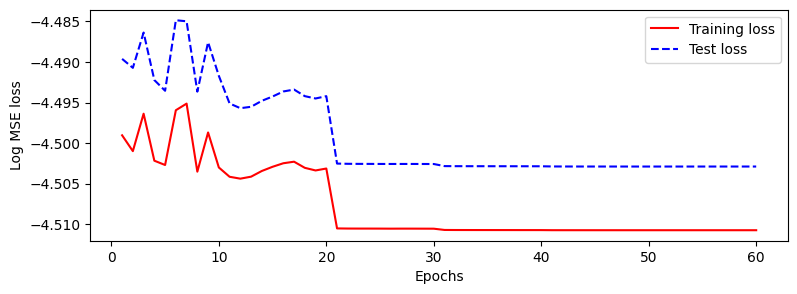

In [ ]:
# model = Heston_ANN()
# model.load_state_dict(torch.load("Heston_ANN_1mil_100_epochs.pt"))
# model.eval()
plt.figure(figsize=(9,3))
plt.plot(np.arange(1,61,1),np.log(np.array(training_loss)),'r',label="Training loss")
plt.plot(np.arange(1,61,1),np.log(np.array(test_loss)),'b',linestyle='dashed',label="Test loss")
plt.xlabel("Epochs")
plt.ylabel("Log MSE loss")
plt.legend()
plt.savefig("log_MSE_loss_IV_1mil_60_epochs.png",dpi=1200)

In fact, we will use this model to fit the volatility surface. We compute the volatility surface for fixed parameters except for maturity and moneyness, which we change to see the implied volatily curve.

In [ ]:
S,mrs,r,volvol,v_bar,rho,sigma,L,N,a,b = 100, 1.5, 0.02, 0.3, 0.1, -0.05, 0.1, 50, 1500, -3, 5
nbr = 15
moneyness = np.linspace(0.7,1.3,nbr)
time_to_maturities = np.linspace(0.5,1,nbr)

prices = np.zeros((len(moneyness),len(time_to_maturities)))
imp_vol = np.zeros((len(moneyness),len(time_to_maturities)))
imp_vol_ann = np.zeros((len(moneyness),len(time_to_maturities)))


X, Y = np.meshgrid(moneyness, time_to_maturities)

for i in range(len(moneyness)):
  K = S/moneyness[i]
  for j in range(len(time_to_maturities)):
    tau = time_to_maturities[j]
    imp_vol[i,j] = implied_vol_(S,K,tau,mrs,r,volvol,v_bar,rho,sigma,L,N,a,b)
    prices[i,j] = Heston_2(S,K,tau,mrs,r,volvol,v_bar,rho,sigma,L,N)
    imp_vol_ann[i,j] = iv_ANN(torch.tensor(np.array([prices[i,j]])).type(torch.float))

### Implied volatilty surface computed by Brent's algorithm :

First, we plot the surface using the implied volatilities computed by Brent's algorithm so we can see what it is supposed to look like.

In [ ]:
import plotly.graph_objects as go
fig = go.Figure(go.Surface(x=time_to_maturities,y=moneyness,z=imp_vol,opacity=0.9, colorscale='Viridis'))
fig.update_layout(scene = dict(
                    xaxis_title='Time to maturity',
                    yaxis_title='Moneyness',
                    zaxis_title='Brent implied volatility'),
                    width=800,
                    height = 700,
                    # margin=dict(r=20, b=10, l=10, t=10)
                    )
fig.show()

### Implied volatility surface using the ANN...

In [ ]:
import plotly.graph_objects as go
fig = go.Figure(go.Surface(x=time_to_maturities,y=moneyness,z=imp_vol_ann,opacity=0.9, colorscale='Viridis'))
fig.update_layout(scene = dict(
                    xaxis_title='Time to maturity',
                    yaxis_title='Moneyness',
                    zaxis_title='ANN implied volatility'),
                    width=800,
                    height = 700,
                    # margin=dict(r=20, b=10, l=10, t=10)
                    )
fig.show()

The volatility range is wrong (it should be between 0.31 and 0.32 at most) and the direction of the curve is also wrong.
<br>
In hindsight, it should have been obvious that a neural network trying to approximate a quantity that depends on multiple parameters should have more than one parameter. And that is made clear by this curve that is completely incorrect.  So that's what the next section is.

## ANN with more parameters

This time, we will keep all the Heston parameters plus the computed price as input. It could be interesting to geneate the Heston prices that are fed into this model by the Heston-ANN rather than the COS method, but since the loss in my Heston ANN is not the best I elected to use the prices computed by the COS method to avoid any error accumulation. It could also be interesting to see how this compares to a network trained on only `(moneyness, tau, price)` as these are generally what we use as variables when we want to see the implied volatily smile. I won't be doing this for lack of time..

In [ ]:
class IV_ANN_2(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear_relu_stack = nn.Sequential(

        nn.Linear(9,400),
        nn.ReLU(),

        nn.Linear(400,400),
        nn.ReLU(),

        nn.Linear(400,400),
        nn.ReLU(),

        nn.Linear(400,400),
        nn.ReLU(),

        nn.Linear(400,1),
    )

  def forward(self,x):
    target = self.linear_relu_stack(x)
    return target

  def weights_init(self): # initializing parameters using glorot uniform unitialization
    for module in self.modules():
      if isinstance(module, nn.Linear):
        nn.init.xavier_uniform_(module.weight)

def train_loop(dataloader, model, loss_fn, optimizer):
  for batch, (X,y) in enumerate(dataloader):
    # forward compute
    pred = model(X)
    # loss = loss_fn(pred,y.unsqueeze(1))
    loss = loss_fn(pred,y)

    # backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [ ]:
H_data = torch.load("H_data.pt") #input to the ann, we're taking all the Heston parameters + the Heston price this time instead of just the price
iv = torch.load("iv.pt") #output of the ann, which is the implied vol computed by Brent's algorithm for each data point in H_data (same output as the previous ANN)

iv_ANN = IV_ANN_2()
iv_ANN.weights_init() #initialize the weights
loss_function = nn.MSELoss()
batch_size = 1000
epochs = 60
optimizer = torch.optim.Adam(iv_ANN.parameters(), lr=10e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

num_iv = 10**6

train_size = int(0.9*num_iv)
X = H_data
Y = iv
Xtrain, Xtest = X[:train_size,:], X[train_size:,:]
Ytrain, Ytest = Y[:train_size], Y[train_size:]

train_set = TensorDataset(Xtrain,Ytrain)
train_dataloader = DataLoader(train_set, batch_size=batch_size)

Looking at the loss for this new model, it already looks much more promising.

In [ ]:
training_loss = []
test_loss = []
for epoch in tqdm(range(epochs)):
  running_training_loss = train_loop(train_dataloader, iv_ANN, loss_function, optimizer)
  running_test_loss = loss_function(iv_ANN(Xtest),Ytest)
  running_training_loss = loss_function(iv_ANN(Xtrain),Ytrain)

  if epoch%5==0:
    print("Test loss :", running_test_loss.detach().numpy())
    print(" Training loss :", running_training_loss.detach().numpy())


  test_loss.append(running_test_loss.detach().numpy())
  training_loss.append(running_training_loss.detach().numpy())

  scheduler.step()

print("Done!")

  2%|▏         | 1/60 [00:58<57:31, 58.50s/it]

Test loss : 0.00050937413
 Training loss : 0.0004583294


 10%|█         | 6/60 [05:47<52:07, 57.92s/it]

Test loss : 0.0003618376
 Training loss : 0.00034330308


 18%|█▊        | 11/60 [10:38<47:57, 58.72s/it]

Test loss : 6.6350636e-05
 Training loss : 5.8591286e-05


 27%|██▋       | 16/60 [16:09<47:14, 64.42s/it]

Test loss : 5.6535333e-05
 Training loss : 5.3478398e-05


 35%|███▌      | 21/60 [21:32<42:27, 65.32s/it]

Test loss : 3.1748823e-05
 Training loss : 2.713907e-05


 43%|████▎     | 26/60 [26:50<36:34, 64.54s/it]

Test loss : 2.9365894e-05
 Training loss : 2.4307912e-05


 52%|█████▏    | 31/60 [32:23<32:23, 67.00s/it]

Test loss : 2.6577827e-05
 Training loss : 2.1510887e-05


 60%|██████    | 36/60 [37:20<24:07, 60.30s/it]

Test loss : 2.62626e-05
 Training loss : 2.1145002e-05


 68%|██████▊   | 41/60 [42:10<18:29, 58.39s/it]

Test loss : 2.5940257e-05
 Training loss : 2.0820138e-05


 77%|███████▋  | 46/60 [47:07<13:44, 58.91s/it]

Test loss : 2.586844e-05
 Training loss : 2.078407e-05


 85%|████████▌ | 51/60 [52:00<08:47, 58.65s/it]

Test loss : 2.583362e-05
 Training loss : 2.075716e-05


 93%|█████████▎| 56/60 [57:06<04:04, 61.21s/it]

Test loss : 2.5814303e-05
 Training loss : 2.0754436e-05


100%|██████████| 60/60 [1:01:36<00:00, 61.61s/it]

Done!


And the overfitting is not so bad either.

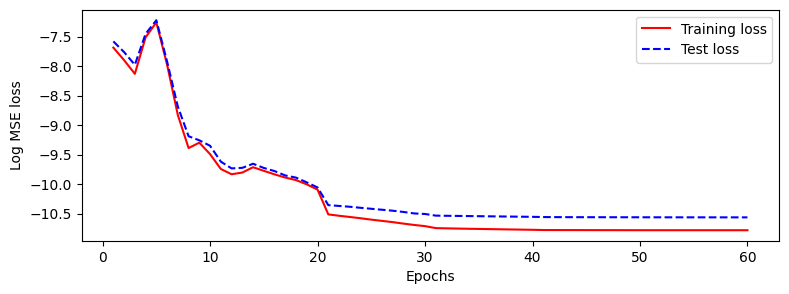

In [ ]:
plt.figure(figsize=(9,3))
plt.plot(np.arange(1,61,1),np.log(np.array(training_loss)),'r',label="Training loss")
plt.plot(np.arange(1,61,1),np.log(np.array(test_loss)),'b',linestyle='dashed',label="Test loss")
plt.xlabel("Epochs")
plt.ylabel("Log MSE loss")
plt.legend()
# plt.savefig("log_MSE_loss_new_IV_1mil_60_epochs.png",dpi=1200)

Now we will use it to generate the volatility surface with the same parameters as before :

In [ ]:
S,mrs,r,volvol,v_bar,rho,sigma,L,N,a,b = 100, 1.5, 0.02, 0.2, 0.1, -0.05, 0.1, 50, 1500, -3, 5
nbr = 15
moneyness = np.linspace(0.7,1.3,nbr)
time_to_maturities = np.linspace(0.5,1,nbr)

prices = np.zeros((len(moneyness),len(time_to_maturities)))
imp_vol = np.zeros((len(moneyness),len(time_to_maturities)))
imp_vol_ann = np.zeros((len(moneyness),len(time_to_maturities)))


X, Y = np.meshgrid(moneyness, time_to_maturities)

for i in range(len(moneyness)):
  K = S/moneyness[i]
  for j in range(len(time_to_maturities)):
    tau = time_to_maturities[j]
    imp_vol[i,j] = implied_vol_(S,K,tau,mrs,r,volvol,v_bar,rho,sigma,L,N,a,b)
    price = Heston_2(S,K,tau,mrs,r,volvol,v_bar,rho,sigma,L,N)
    imp_vol_ann[i,j] = iv_ANN(torch.tensor([S/K,tau,mrs,r,volvol,v_bar,rho,sigma,price]).type(torch.float))

In [ ]:
import plotly.graph_objects as go
fig = go.Figure(go.Surface(x=time_to_maturities,y=moneyness,z=imp_vol_ann,opacity=0.9, colorscale='Viridis'))
fig.update_layout(scene = dict(
                    xaxis_title='Time to maturity',
                    yaxis_title='Moneyness',
                    zaxis_title='ANN implied volatility'),
                    width=800,
                    height = 700,
                    # margin=dict(r=20, b=10, l=10, t=10)
                    )
fig.show()

The volatility range is an improvement from the last model, and also the curve generally follows the shape of the volatility smile. Unfortunately, the surface generated by this model is very bumpy.
<br>
The article mentions flattening the prices fed into the model in order to flatten the gradients, so that's what this next section is about. This time we feed the log of the time value of the option divided by the strike into the ANN isntead of just the price.

In [ ]:
H = torch.column_stack((H_data, iv))
H_positive_data = H[H[:,-2]>0]
I = torch.ones_like(H_positive_data[:,-1])
H_positive_data[:,-2] = H_positive_data[:,-2] - torch.maximum( S*I - (S/H_positive_data[:,0])*torch.exp(-H_positive_data[:,3]*H_positive_data[:,1]), torch.zeros_like(H_positive_data[:,-2])) *  ( S*I >= S/H_positive_data[:,0])

H_positive_data = H_positive_data[H_positive_data[:,-2]>0]
H_positive_data[:,-2] = torch.log( H_positive_data[:,-2] / (S/H_positive_data[:,0]) )

In [ ]:
iv_ANN_2 = IV_ANN_2()
iv_ANN_2.weights_init() #initialize the weights
loss_function = nn.MSELoss()
batch_size = 1000
epochs = 60
optimizer = torch.optim.Adam(iv_ANN_2.parameters(), lr=10e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

num_iv = 10**6

train_size = int(0.9*num_iv)
X = H_positive_data[:,:-1]
Y = H_positive_data[:,-1]
Xtrain, Xtest = X[:train_size,:], X[train_size:,:]
Ytrain, Ytest = Y[:train_size].unsqueeze(1), Y[train_size:].unsqueeze(1)

train_set = TensorDataset(Xtrain,Ytrain)
train_dataloader = DataLoader(train_set, batch_size=batch_size)

In [ ]:
training_loss = []
test_loss = []
for epoch in tqdm(range(epochs)):
  running_training_loss = train_loop(train_dataloader, iv_ANN_2, loss_function, optimizer)
  running_test_loss = loss_function(iv_ANN_2(Xtest),Ytest)
  running_training_loss = loss_function(iv_ANN_2(Xtrain),Ytrain)

  if epoch%5==0:
    print("Test loss :", running_test_loss.detach().numpy())
    print(" Training loss :", running_training_loss.detach().numpy())


  test_loss.append(running_test_loss.detach().numpy())
  training_loss.append(running_training_loss.detach().numpy())

  scheduler.step()

print("Done!")

  2%|▏         | 1/60 [01:05<1:04:15, 65.35s/it]

Test loss : 0.00013774063
 Training loss : 0.00014322266


 10%|█         | 6/60 [05:58<53:11, 59.10s/it]

Test loss : 3.294881e-05
 Training loss : 2.415151e-05


 18%|█▊        | 11/60 [10:52<47:58, 58.74s/it]

Test loss : 1.4594879e-05
 Training loss : 1.0383299e-05


 27%|██▋       | 16/60 [15:48<43:00, 58.65s/it]

Test loss : 1.3448717e-05
 Training loss : 9.473456e-06


 35%|███▌      | 21/60 [20:40<37:57, 58.40s/it]

Test loss : 7.2447056e-06
 Training loss : 4.643843e-06


 43%|████▎     | 26/60 [25:34<33:15, 58.70s/it]

Test loss : 7.08603e-06
 Training loss : 4.4410344e-06


 52%|█████▏    | 31/60 [30:28<28:23, 58.75s/it]

Test loss : 6.573434e-06
 Training loss : 4.054843e-06


 60%|██████    | 36/60 [35:22<23:28, 58.69s/it]

Test loss : 6.5311074e-06
 Training loss : 4.0255363e-06


 68%|██████▊   | 41/60 [40:19<18:45, 59.26s/it]

Test loss : 6.5076706e-06
 Training loss : 3.992786e-06


 77%|███████▋  | 46/60 [45:11<13:39, 58.50s/it]

Test loss : 6.5139943e-06
 Training loss : 3.987681e-06


 85%|████████▌ | 51/60 [50:06<08:50, 58.90s/it]

Test loss : 6.5116983e-06
 Training loss : 3.984569e-06


 93%|█████████▎| 56/60 [55:01<03:56, 59.12s/it]

Test loss : 6.5133117e-06
 Training loss : 3.984248e-06


100%|██████████| 60/60 [59:03<00:00, 59.05s/it]

Done!


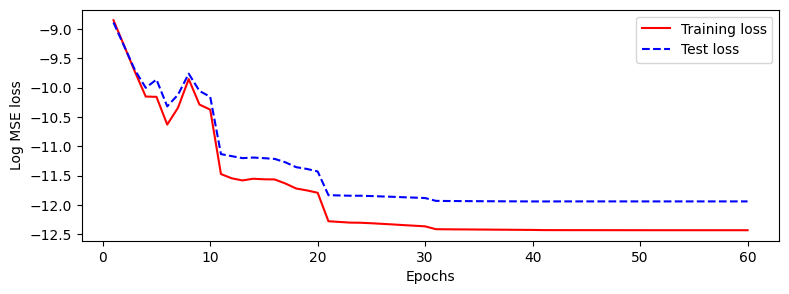

In [ ]:
plt.figure(figsize=(9,3))
plt.plot(np.arange(1,61,1),np.log(np.array(training_loss)),'r',label="Training loss")
plt.plot(np.arange(1,61,1),np.log(np.array(test_loss)),'b',linestyle='dashed',label="Test loss")
plt.xlabel("Epochs")
plt.ylabel("Log MSE loss")
plt.legend()
# plt.savefig("log_MSE_loss_new_new_IV_1mil_60_epochs.png",dpi=1200)

We hope that this change makes the volatility surface smoother, and to a certain extent it does, although it is still not perfect.

In [ ]:
S,mrs,r,volvol,v_bar,rho,sigma,L,N,a,b = 100, 1.5, 0.02, 0.3, 0.1, -0.05, 0.1, 50, 1500, -3, 5
nbr = 10
moneyness = np.linspace(0.7,1.3,nbr)
time_to_maturities = np.linspace(0.5,1,nbr)

prices = np.zeros((len(moneyness),len(time_to_maturities)))
imp_vol = np.zeros((len(moneyness),len(time_to_maturities)))
imp_vol_ann = np.zeros((len(moneyness),len(time_to_maturities)))


X, Y = np.meshgrid(moneyness, time_to_maturities)

for i in range(len(moneyness)):
  K = S/moneyness[i]
  for j in range(len(time_to_maturities)):
    tau = time_to_maturities[j]
    imp_vol[i,j] = implied_vol_(S,K,tau,mrs,r,volvol,v_bar,rho,sigma,L,N,a,b)
    price = Heston_2(S,K,tau,mrs,r,volvol,v_bar,rho,sigma,L,N)
    price_tilt = price - max(S-K*np.exp(-r*tau),0)*(S>K)
    imp_vol_ann[i,j] = iv_ANN_2(torch.tensor([S/K,tau,mrs,r,volvol,v_bar,rho,sigma,np.log(price_tilt)-np.log(K)]).type(torch.float))

In [ ]:
import plotly.graph_objects as go
fig = go.Figure(go.Surface(x=time_to_maturities,y=moneyness,z=imp_vol_ann,opacity=0.9, colorscale='Viridis'))
fig.update_layout(scene = dict(
                    xaxis_title='Time to maturity',
                    yaxis_title='Moneyness',
                    zaxis_title='ANN implied volatility'),
                    width=800,
                    height = 700,
                    # margin=dict(r=20, b=10, l=10, t=10)
                    )
fig.show()

We can also plot the difference between the surface given by the ANN and the one given by Brent's method in a sort of heatmap to see how far off we are from the correct values. The map shows that although the surface isn't very smooth, the error is not so bad.

In [ ]:
S,mrs,r,volvol,v_bar,rho,sigma,L,N,a,b = 100, 1.5, 0.02, 0.3, 0.1, -0.05, 0.1, 50, 1500, -3, 5
nbr = 50
moneyness = np.linspace(0.7,1.3,nbr)
time_to_maturities = np.linspace(0.5,1,nbr)

prices = np.zeros((len(moneyness),len(time_to_maturities)))
imp_vol = np.zeros((len(moneyness),len(time_to_maturities)))
imp_vol_ann = np.zeros((len(moneyness),len(time_to_maturities)))


X, Y = np.meshgrid(moneyness, time_to_maturities)

for i in range(len(moneyness)):
  K = S/moneyness[i]
  for j in range(len(time_to_maturities)):
    tau = time_to_maturities[j]
    imp_vol[i,j] = implied_vol_(S,K,tau,mrs,r,volvol,v_bar,rho,sigma,L,N,a,b)
    price = Heston_2(S,K,tau,mrs,r,volvol,v_bar,rho,sigma,L,N)
    price_tilt = price - max(S-K*np.exp(-r*tau),0)*(S>K)
    imp_vol_ann[i,j] = iv_ANN_2(torch.tensor([S/K,tau,mrs,r,volvol,v_bar,rho,sigma,np.log(price_tilt)-np.log(K)]).type(torch.float))

diff = imp_vol - imp_vol_ann
fig = px.imshow(diff,color_continuous_scale='Viridis',x=moneyness,y=time_to_maturities)
fig.show()